<a href="https://colab.research.google.com/github/ml2-picme/PicMe/blob/master/Image%20Download%20and%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Helper Functions

### Needed libraries for this notebook

In [1]:
import sys
from urllib.request import urlopen
from keras.applications import *

Using TensorFlow backend.


### First clone the Github Project itself, to be able to add the functions defined in the ./scripts sub-directory

In [2]:
# Remove Path if already existing locally
!rm -r PicMe

# Clone Git repository
!git clone https://github.com/ml2-picme/PicMe.git

# Add the relevant paths of the repo to system path
sys.path.append("/content/PicMe")
sys.path.append("/content/PicMe/scripts")

# Add the functions, defined in the script files
from file_processing import *
from image_classification import *
from imagenet_tree_search import *
from text_processing import *

rm: cannot remove 'PicMe': No such file or directory
Cloning into 'PicMe'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 485 (delta 45), reused 9 (delta 3), pack-reused 393
Receiving objects: 100% (485/485), 12.92 MiB | 22.88 MiB/s, done.
Resolving deltas: 100% (256/256), done.


In [0]:
# author: tai.truong@software-developer.org. @see https://github.com/ml2-picme/PicMe, imagenet_processing_script.py
parentToChildrenDictionary = getParentToChildrenDictionary()
childToParentsDictionary = getChildToParentsDictionary()

In [0]:
def expandResultsByImageNetTreeSearch(synsetId, localPath, modelName, predicationProbability):
  results = getWords(synsetId, parentToChildrenDictionary, childToParentsDictionary)
  
  cnx = mysql.connector.connect(user='ml2', password='ml2@hsOg#2019!',
                              host='192.52.33.218',
                              database='ml2',
                              autocommit=True)
  cursor = cnx.cursor()
  add_result = ("insert ignore into results (local_path, model, prediction_class, prediction_probability) values (%s, %s, %s, %s)")
  
  for result in results:
    data_result = (localPath, modelName, result, float(predicationProbability))
    cursor.execute(add_result, data_result)
    result_id = cursor.lastrowid
        
    print(result_id, " | ", localPath, " | ", modelName, " | ", result, " | ", predicationProbability)
       
    cnx.commit()
        
  cursor.close()
  cnx.close()
  
  

In [5]:
# MySQL Part -> Writing Image Classification Results to DB
!pip install mysql-connector-python-rf

import mysql.connector

def storeResultsToDB(fileNames, resultsList, modelList):
  
  cnx = mysql.connector.connect(user='ml2', password='ml2@hsOg#2019!',
                              host='192.52.33.218',
                              database='ml2',
                              autocommit=True)
  cursor = cnx.cursor()
  add_result = ("insert ignore into results (local_path, model, prediction_class, prediction_probability) values (%s, %s, %s, %s)")
  
  for k in range(len(modelList)):
    
    print("==== other model =====")
    
    for i in range(len(fileNames)):
      
      print("==== other file =====")
      
      for j in range(5):
        
        print("Counter:")
        print("Model", (k+1), "von", len(modelList))
        print("File", (i+1), "von", len(fileNames))
        print("Platz", (j+1), "von", 5)
        
        fileName = fileNames[i]
        modelName = modelList[k]
        predictedClassSynsetId = resultsList[k][i][j][0]
        predictedClass = resultsList[k][i][j][1]
        predictedPropability = resultsList[k][i][j][2]
  
        #print(fileName)
        #print(modelName)
        #print(predictedClass)
        #print(predictedPropability)
        #print("==============")
        
        data_result = (fileName, modelName, predictedClass, float(predictedPropability))
        cursor.execute(add_result, data_result)
        result_id = cursor.lastrowid
        
        print(result_id, " | ", fileName, " | ", modelName, " | ", predictedClass, " | ", predictedPropability)
       
        cnx.commit()
        
        print("Now searching for similar words in ImageNet tree (parent / child search)")
        
        expandResultsByImageNetTreeSearch(predictedClassSynsetId, fileName, modelName, predictedPropability)
        
  cursor.close()
  cnx.close()

     |████████████████████████████████| 11.9MB 3.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/87/58/fb/d95c84fad7e1bebfed324c13e107ebb08e1997c9226532859a
Successfully built mysql-connector-python-rf


In [6]:
!pip install mysql-connector-python-rf

import mysql.connector
import matplotlib.pyplot as plt

def querySearchWord(searchWord):
  cnx = mysql.connector.connect(user='ml2', password='ml2@hsOg#2019!',
                              host='192.52.33.218',
                              database='ml2',
                              autocommit=True)
  cursor = cnx.cursor()
  query = ("select distinct local_path, prediction_class from results where prediction_class = %s")
  
  cursor.execute(query, (searchWord,))
  
  print("Found following files for your search word \"" + searchWord + "\":")
  
  for (local_path, prediction_class) in cursor:
    foundFiles = [open(local_path, 'rb')]
    preparedImage224x224 = prepareImagesForClassification(foundFiles, 224, 224)[0]

    plt.figure()
    plt.imshow(preparedImage224x224)
    plt.title("{}".format(local_path))
    plt.axis('off')
    plt.show()
    plt.clf()



  cursor.close()
  cnx.close()  

## Logic

In [0]:
# Parameters
path = "/tmp/image_classification"
hashrange = 20

In [8]:
# Preparation: Delete local files
deleteLocalDirectory(path)

Delete local directory: /tmp/image_classification - Failed


In [9]:
# Preparation: Create local directory structure
for i in range(hashrange):
  if(i % 10 == 0):
    parentPath = path + "/" + str((int)(i/10))
    createLocalDirectory(parentPath)
  normalizedI = '%02d' % i  # Normalization, pad zeroes
  filePath = parentPath + "/" + normalizedI
  createLocalDirectory(filePath)

Create local directory: /tmp/image_classification/0	 - OK
Create local directory: /tmp/image_classification/0/00	 - OK
Create local directory: /tmp/image_classification/0/01	 - OK
Create local directory: /tmp/image_classification/0/02	 - OK
Create local directory: /tmp/image_classification/0/03	 - OK
Create local directory: /tmp/image_classification/0/04	 - OK
Create local directory: /tmp/image_classification/0/05	 - OK
Create local directory: /tmp/image_classification/0/06	 - OK
Create local directory: /tmp/image_classification/0/07	 - OK
Create local directory: /tmp/image_classification/0/08	 - OK
Create local directory: /tmp/image_classification/0/09	 - OK
Create local directory: /tmp/image_classification/1	 - OK
Create local directory: /tmp/image_classification/1/10	 - OK
Create local directory: /tmp/image_classification/1/11	 - OK
Create local directory: /tmp/image_classification/1/12	 - OK
Create local directory: /tmp/image_classification/1/13	 - OK
Create local directory: /tmp/i

In [10]:
filesDict = {}

data = urlopen("https://raw.githubusercontent.com/ml2-picme/PicMe/master/input/images_subset.txt")
for line in data:
  if not line.startswith(b'#'):  # Ignore Lines that begin with a comment (#)
    line = line.decode("utf-8").split("\n")[0]  # Normalization
    url = line.split(";")[0]
    label = line.split(";")[1]
    
    filename = getFileNameFromPath(url)

    hashvalue = abs(hash(filename)) % hashrange
    parent_dir = (int)(hashvalue / 10)
    hashvalue = '%02d' % hashvalue  # Normalization, pad zeroes
    
    filetype = filename.split(".")[len(filename.split(".")) - 1]
    newFilename = label + "." + filetype
    #print(newFilename)

    print(url, " -> ", hashvalue, " -> ", label, " -> ", parent_dir, " -> ", filename)

    localPath = path + "/" + str(parent_dir) + "/" + hashvalue + "/" + newFilename

    downloadFileFromUrl(url, localPath)
    
    filesDict[localPath] = url
    
for x, y in filesDict.items():
  print(x, "->", y)

https://www.tierpark-sababurg.de/fileadmin/_processed_/7/d/csm__MG_9788_852e2bbcb9.jpg  ->  09  ->  Bird  ->  0  ->  csm__MG_9788_852e2bbcb9.jpg
Download https://www.tierpark-sababurg.de/fileadmin/_processed_/7/d/csm__MG_9788_852e2bbcb9.jpg to /tmp/image_classification/0/09/Bird.jpg
https://www.genussvoll-dampfen.de/images/product_images/original_images/popcorn.png  ->  09  ->  Popcorn  ->  0  ->  popcorn.png
Download https://www.genussvoll-dampfen.de/images/product_images/original_images/popcorn.png to /tmp/image_classification/0/09/Popcorn.png
https://images.pickawood.com/data/nettece/aaa-images/customer-images/regal-buecherregal-bibliothek-kiefer-13301-980x720.jpg  ->  07  ->  Bookshelf  ->  0  ->  regal-buecherregal-bibliothek-kiefer-13301-980x720.jpg
Download https://images.pickawood.com/data/nettece/aaa-images/customer-images/regal-buecherregal-bibliothek-kiefer-13301-980x720.jpg to /tmp/image_classification/0/07/Bookshelf.jpg
https://www.adac.de/-/media/images/rechtsberatung/tan

In [11]:
extensionsToCheck = [".jpg", ".png", ".bmp"]
foundFiles = findFilesInPathByFileExtension(path, extensionsToCheck)

for foundFile in foundFiles:
  print(foundFile)

preparedImages224x224 = prepareImagesForClassification(foundFiles, 224, 224)
preparedImages299x299 = prepareImagesForClassification(foundFiles, 299, 299)

/tmp/image_classification/0/06/Tractor.jpg
/tmp/image_classification/0/09/Popcorn.png
/tmp/image_classification/0/09/Bird.jpg
/tmp/image_classification/0/03/PetrolStation.jpg
/tmp/image_classification/0/07/Bookshelf.jpg
/tmp/image_classification/1/11/Apple.jpg


In [12]:
# Achtung: Hier werden Funktionen übergeben: 
# 1) preprocess_input Funktion
# 2) decode_predictions Funktion
# => Dies sorgt dafür, dass die gesamte Klassifizierung ausgelagert und dynamisch aufgerufen werden kann!

predictedClassesVGG16 = classifyImages(preparedImages224x224, vgg16.preprocess_input, vgg16.decode_predictions, vgg16.VGG16(input_shape=(224, 224, 3)))
predictedClassesVGG19 = classifyImages(preparedImages224x224, vgg19.preprocess_input, vgg19.decode_predictions, vgg19.VGG19(input_shape=(224, 224, 3)))
predictedClassesMobileNetV2 = classifyImages(preparedImages224x224, mobilenet_v2.preprocess_input, mobilenet_v2.decode_predictions, mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3)))
predictedClassesResNet50 = classifyImages(preparedImages224x224, resnet50.preprocess_input, resnet50.decode_predictions, resnet50.ResNet50(input_shape=(224, 224, 3)))
predictedClassesDenseNet201 = classifyImages(preparedImages224x224, densenet.preprocess_input, densenet.decode_predictions, densenet.DenseNet201(input_shape=(224, 224, 3)))
predictedClassesInceptionV3 = classifyImages(preparedImages299x299, inception_v3.preprocess_input, inception_v3.decode_predictions, inception_v3.InceptionV3(input_shape=(299, 299, 3)))
predictedClassesXception = classifyImages(preparedImages299x299, xception.preprocess_input, xception.decode_predictions, xception.Xception(input_shape=(299, 299, 3)))
predictedClassesInceptionResNet = classifyImages(preparedImages299x299, inception_resnet_v2.preprocess_input, inception_resnet_v2.decode_predictions,inception_resnet_v2.InceptionResNetV2(input_shape=(299, 299, 3)))

Instructions for updating:
Colocations handled automatically by placer.
6/6 [==============================] - 15s 3s/step


Comparing the Results for File: /tmp/image_classification/0/06/Tractor.jpg


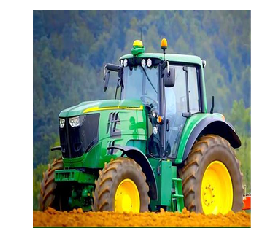

 > Top 1 @ VGG16 : ('n03967562', 'plow', 0.41891932)
 > Top 1 @ VGG19 : ('n03967562', 'plow', 0.63408697)
 > Top 1 @ MobileNetV2 : ('n03496892', 'harvester', 0.25270432)
 > Top 1 @ ResNet50 : ('n03967562', 'plow', 0.8275722)
 > Top 1 @ DenseNet201 : ('n03967562', 'plow', 0.5116457)
 > Top 1 @ InceptionV3 : ('n04465501', 'tractor', 0.54141)
 > Top 1 @ Xception : ('n03967562', 'plow', 0.62519807)
 > Top 1 @ InceptionResNet : ('n03967562', 'plow', 0.5941059)
 > Top 2 @ VGG16 : ('n04252225', 'snowplow', 0.3131355)
 > Top 2 @ VGG19 : ('n03496892', 'harvester', 0.15822224)
 > Top 2 @ MobileNetV2 : ('n04465501', 'tractor', 0.21725044)
 > Top 2 @ ResNet50 : ('n04465501', 'tractor', 0.09105374)
 > Top 2 @ DenseNet201 : ('n04465501', 'tractor', 0.44440255)
 > Top 2 @ InceptionV3 : ('n03496892', 'harvester', 0.21675688)
 > Top 2 @ Xception : ('n04465501', 'tractor', 0.15786165)
 > Top 2 @ InceptionResNet : ('n04465501', 'tractor', 0.16575545)
 > Top 3 @ VGG16 : ('n03496892', 'harvester', 0.140339

<Figure size 432x288 with 0 Axes>

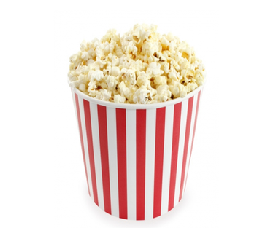

 > Top 1 @ VGG16 : ('n02909870', 'bucket', 0.35633236)
 > Top 1 @ VGG19 : ('n02909870', 'bucket', 0.14817701)
 > Top 1 @ MobileNetV2 : ('n07930864', 'cup', 0.15400416)
 > Top 1 @ ResNet50 : ('n07614500', 'ice_cream', 0.22111315)
 > Top 1 @ DenseNet201 : ('n12144580', 'corn', 0.15515503)
 > Top 1 @ InceptionV3 : ('n02909870', 'bucket', 0.6540217)
 > Top 1 @ Xception : ('n02909870', 'bucket', 0.4912388)
 > Top 1 @ InceptionResNet : ('n07614500', 'ice_cream', 0.48130676)
 > Top 2 @ VGG16 : ('n02747177', 'ashcan', 0.11119151)
 > Top 2 @ VGG19 : ('n07930864', 'cup', 0.14475457)
 > Top 2 @ MobileNetV2 : ('n07932039', 'eggnog', 0.1431501)
 > Top 2 @ ResNet50 : ('n07932039', 'eggnog', 0.20968619)
 > Top 2 @ DenseNet201 : ('n03062245', 'cocktail_shaker', 0.13816525)
 > Top 2 @ InceptionV3 : ('n02747177', 'ashcan', 0.13733281)
 > Top 2 @ Xception : ('n03991062', 'pot', 0.11282562)
 > Top 2 @ InceptionResNet : ('n07930864', 'cup', 0.14059414)
 > Top 3 @ VGG16 : ('n03908714', 'pencil_sharpener', 0

<Figure size 432x288 with 0 Axes>

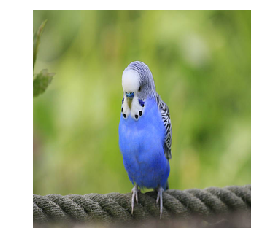

 > Top 1 @ VGG16 : ('n01818515', 'macaw', 0.68094575)
 > Top 1 @ VGG19 : ('n01537544', 'indigo_bunting', 0.62846345)
 > Top 1 @ MobileNetV2 : ('n01580077', 'jay', 0.15119007)
 > Top 1 @ ResNet50 : ('n01580077', 'jay', 0.40537375)
 > Top 1 @ DenseNet201 : ('n01537544', 'indigo_bunting', 0.6217525)
 > Top 1 @ InceptionV3 : ('n01580077', 'jay', 0.06271331)
 > Top 1 @ Xception : ('n01580077', 'jay', 0.08950132)
 > Top 1 @ InceptionResNet : ('n01537544', 'indigo_bunting', 0.41280684)
 > Top 2 @ VGG16 : ('n01806143', 'peacock', 0.14961304)
 > Top 2 @ VGG19 : ('n01580077', 'jay', 0.31593624)
 > Top 2 @ MobileNetV2 : ('n01818515', 'macaw', 0.12561554)
 > Top 2 @ ResNet50 : ('n01806143', 'peacock', 0.3823272)
 > Top 2 @ DenseNet201 : ('n01580077', 'jay', 0.2346475)
 > Top 2 @ InceptionV3 : ('n01537544', 'indigo_bunting', 0.05657884)
 > Top 2 @ Xception : ('n01537544', 'indigo_bunting', 0.08405033)
 > Top 2 @ InceptionResNet : ('n01580077', 'jay', 0.22181836)
 > Top 3 @ VGG16 : ('n01580077', 'ja

<Figure size 432x288 with 0 Axes>

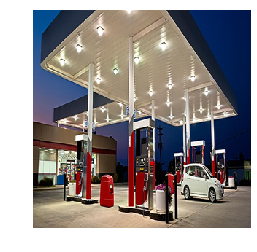

 > Top 1 @ VGG16 : ('n03032252', 'cinema', 0.35319147)
 > Top 1 @ VGG19 : ('n03425413', 'gas_pump', 0.7898903)
 > Top 1 @ MobileNetV2 : ('n03425413', 'gas_pump', 0.6275591)
 > Top 1 @ ResNet50 : ('n03425413', 'gas_pump', 0.97078234)
 > Top 1 @ DenseNet201 : ('n03425413', 'gas_pump', 0.990035)
 > Top 1 @ InceptionV3 : ('n03425413', 'gas_pump', 0.9944454)
 > Top 1 @ Xception : ('n03425413', 'gas_pump', 0.800127)
 > Top 1 @ InceptionResNet : ('n03425413', 'gas_pump', 0.92290676)
 > Top 2 @ VGG16 : ('n03425413', 'gas_pump', 0.26824278)
 > Top 2 @ VGG19 : ('n03032252', 'cinema', 0.0773763)
 > Top 2 @ MobileNetV2 : ('n03032252', 'cinema', 0.055201244)
 > Top 2 @ ResNet50 : ('n04507155', 'umbrella', 0.0067533515)
 > Top 2 @ DenseNet201 : ('n03032252', 'cinema', 0.0022459568)
 > Top 2 @ InceptionV3 : ('n03899768', 'patio', 0.0003055364)
 > Top 2 @ Xception : ('n04239074', 'sliding_door', 0.026583647)
 > Top 2 @ InceptionResNet : ('n02025239', 'ruddy_turnstone', 0.0007798422)
 > Top 3 @ VGG16 :

<Figure size 432x288 with 0 Axes>

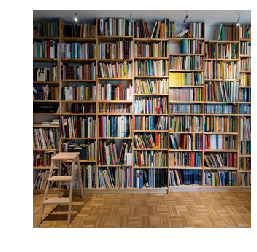

 > Top 1 @ VGG16 : ('n02871525', 'bookshop', 0.8277545)
 > Top 1 @ VGG19 : ('n02871525', 'bookshop', 0.7488987)
 > Top 1 @ MobileNetV2 : ('n02871525', 'bookshop', 0.6064253)
 > Top 1 @ ResNet50 : ('n02871525', 'bookshop', 0.9171724)
 > Top 1 @ DenseNet201 : ('n02871525', 'bookshop', 0.73326385)
 > Top 1 @ InceptionV3 : ('n02871525', 'bookshop', 0.4921339)
 > Top 1 @ Xception : ('n02871525', 'bookshop', 0.79796994)
 > Top 1 @ InceptionResNet : ('n02871525', 'bookshop', 0.93719864)
 > Top 2 @ VGG16 : ('n03661043', 'library', 0.1240967)
 > Top 2 @ VGG19 : ('n03661043', 'library', 0.15137787)
 > Top 2 @ MobileNetV2 : ('n03661043', 'library', 0.19319955)
 > Top 2 @ ResNet50 : ('n02870880', 'bookcase', 0.06485266)
 > Top 2 @ DenseNet201 : ('n02870880', 'bookcase', 0.12192985)
 > Top 2 @ InceptionV3 : ('n02870880', 'bookcase', 0.44946086)
 > Top 2 @ Xception : ('n02870880', 'bookcase', 0.0595451)
 > Top 2 @ InceptionResNet : ('n02870880', 'bookcase', 0.009240019)
 > Top 3 @ VGG16 : ('n0287088

<Figure size 432x288 with 0 Axes>

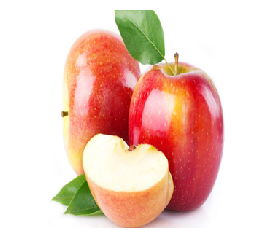

 > Top 1 @ VGG16 : ('n07768694', 'pomegranate', 0.5089675)
 > Top 1 @ VGG19 : ('n07720875', 'bell_pepper', 0.8536335)
 > Top 1 @ MobileNetV2 : ('n07742313', 'Granny_Smith', 0.20737651)
 > Top 1 @ ResNet50 : ('n07768694', 'pomegranate', 0.22960566)
 > Top 1 @ DenseNet201 : ('n07742313', 'Granny_Smith', 0.408252)
 > Top 1 @ InceptionV3 : ('n07742313', 'Granny_Smith', 0.66120636)
 > Top 1 @ Xception : ('n07742313', 'Granny_Smith', 0.8777013)
 > Top 1 @ InceptionResNet : ('n07742313', 'Granny_Smith', 0.83020556)
 > Top 2 @ VGG16 : ('n07742313', 'Granny_Smith', 0.105925344)
 > Top 2 @ VGG19 : ('n07742313', 'Granny_Smith', 0.0356201)
 > Top 2 @ MobileNetV2 : ('n07768694', 'pomegranate', 0.064140655)
 > Top 2 @ ResNet50 : ('n07745940', 'strawberry', 0.16482922)
 > Top 2 @ DenseNet201 : ('n07749582', 'lemon', 0.062925264)
 > Top 2 @ InceptionV3 : ('n07753113', 'fig', 0.0694011)
 > Top 2 @ Xception : ('n07749582', 'lemon', 0.015785309)
 > Top 2 @ InceptionResNet : ('n07747607', 'orange', 0.0178

<Figure size 432x288 with 0 Axes>

In [13]:
resultsList = [predictedClassesVGG16, predictedClassesVGG19, predictedClassesMobileNetV2, predictedClassesResNet50, predictedClassesDenseNet201, predictedClassesInceptionV3, predictedClassesXception, predictedClassesInceptionResNet]
modelList = ['VGG16', 'VGG19', 'MobileNetV2', 'ResNet50', 'DenseNet201', 'InceptionV3', 'Xception', 'InceptionResNet']

# Diese compareResults Methode braucht 4 Parameter:
# 1. Die Liste der Dateinamen
# 2. Die Ergebnisse der einzelnen Modellen, als Array zusammengefasst
# 3. Die Namen der Modelle, einfach als String Array
# 4. Threshold (mind. Sicherheit der Modellvorhersage) => nach Treffen am 17.04. auf 0.0 gesetzt (= kein Filter)
compareResults(foundFiles, resultsList, modelList, 0.00, preparedImages299x299)

In [14]:
allResultsCsv = generateCsvForModelComparison(foundFiles, resultsList, modelList, filesDict, getFileNameFromPath)

for result in allResultsCsv:
  print(result)

NameError: ignored

In [0]:
storeResultsToDB(foundFiles, resultsList, modelList)

In [0]:
querySearchWord("bucket")